# Movies and Statistics

This notebook guides you through a real application of Pandas to study gender bias in film scripts. In particular we want to ask whether gender is associated with the ages of characters, and whether the fraction of dialogue spoken by women changes significantly over historical time.

We'll do some "data munging" (reorganizing and summarizing the data) to produce a data frame that has all the information we need. Then we'll run some simple statistical tests.

We're drawing our data from [this blog post by Hannah Anderson and Matt Daniels](https://pudding.cool/2017/03/film-dialogue/). It organizes data for about 2000 screenplays, and reveals a number of patterns with gorgeous dataviz, but doesn't directly answer the question we want to pose.

However, the authors of the project also posted their data [on GitHub,](https://github.com/matthewfdaniels/scripts/) and I've placed it in this folder.

We start by importing the modules we need. Because the word "pandas" is long if you have to type it a lot, it's conventionally imported *as* pd.

I'm also going to import a basic graphics library ("pyplot") that I'll use to put some titles on graphs, draw a few lines on them, etc. I won't stress the dataviz aspect of this notebook, because in the long run there are more elegant ways to do dataviz in Python (e.g. with the seaborn library). For now I'm trying to rely mostly on Pandas itself, using simple pandas functions like ```.plot()``` and ```.hist()```.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

### Meet your data

The data, as made available by Anderson and Daniels, is in two separate tables. One table has a row for each *character,* and lists the character's gender, along with their age, and the number of words they speak in the movie.

The first time I ran this it didn't work. I got a "UnicodeDecodeError." That's usually a clue that the file has a different encoding. "Utf-8" is default, but this file was created using "latin1," maybe in Excel.

In [3]:
characters = pd.read_csv('character_list5.csv', encoding = 'latin1')  # note encoding
characters.head()

,script_id,imdb_character_name,words,gender,age
0,280,betty,311,f,35.0
1,280,carolyn johnson,873,f,NaN
2,280,eleanor,138,f,NaN
3,280,francesca johns,2251,f,46.0
4,280,madge,190,f,46.0


There are some interesting questions about "coding rules" here. "Age" really means the age of the actor who was portraying a character; it's not necessarily the fictive age of the character, which may not be specidied. What about nonbinary characters? Do, e.g. the minions in _Despicable Me_ have a gender? For that matter, are they speaking "words"? 

These are legitimate questions, but don't directly concern us in this notebook. For one thing, we're not really assuming that this data set is a representative sample of all film. It has selection biases (e.g., it relies on digitized scripts), and we would need to investigate those biases before we could confidently affirm that generalizations about this data reflect the real history of film, even in North America. But we don't need to affirm that. Our goal here is not to make claims about film history. It's just to practice inferential statistics with pandas. 

If you wonder how much this does reflect the real world, you can consult [the project's FAQ page,](https://medium.com/@matthew_daniels/faq-for-the-film-dialogue-by-gender-project-40078209f751) where Daniels bravely faces "death from a thousand nitpicks."

We've looked at a table of characters. There's also a second table of films. This has a row for each movie (```script_id```) and lists titles, along with release year and gross, in inflation-adjusted millions of dollars.

In [4]:
movies = pd.read_csv('meta_data7.csv', encoding = 'latin1')
movies.head()

,script_id,imdb_id,title,year,gross,lines_data
0,1534,tt1022603,(500) Days of Summer,2009,37.0,7435445256774774443342577775657744434444564456...
1,1512,tt0147800,10 Things I Hate About You,1999,65.0,1777752320274533344457777722433777334443764677...
2,1514,tt0417385,12 and Holding,2005,NaN,5461357777754212454544441367774433446547647753...
3,1517,tt2024544,12 Years a Slave,2013,60.0,4567334777777777777777447777756477777444777777...
4,1520,tt1542344,127 Hours,2010,20.0,453513352345765766777777773340


Ignore ```lines_data```; it's an idiosyncratic way to represent changing gender proportions across script time.

### Selecting subsets of a data frame

Part of this was covered in Melanie Walsh's introduction to Pandas, but let's review quickly, and go a little further. I encourage you to change the string values in the following code, and experiment with selecting different films.

First, let's select a column.

In [5]:
movies['title']

0             (500) Days of Summer
1       10 Things I Hate About You
2                   12 and Holding
3                 12 Years a Slave
4                        127 Hours
                   ...            
1995               Youth in Revolt
1996              Zero Dark Thirty
1997                   Zero Effect
1998                    Zerophilia
1999                        Zodiac
Name: title, Length: 2000, dtype: object

Now select rows, using the 'filter' technique that Walsh demonstrates.

In [6]:
matrix_title_filter = movies['title'] == 'The Matrix'
movies[matrix_title_filter]

,script_id,imdb_id,title,year,gross,lines_data
1690,1141,tt0133093,The Matrix,1999,292.0,1446543347777767751307777767756677777767777777...


Now we that we have the script_id for "The Matrix," we can select characters from that movie.

In [7]:
matrix_character_filter = characters['script_id'] == 1141
characters[matrix_character_filter]

,script_id,imdb_character_name,words,gender,age
2095,1141,agent smith,976,m,39.0
2096,1141,morpheus,2123,m,38.0
2097,1141,neo,995,m,35.0
2098,1141,oracle,208,f,66.0
2099,1141,tank,535,m,32.0
2100,1141,trinity,876,f,32.0


Here's a one-line syntax for that filtering technique, which allows you to select rows and columns at the same time.

In [8]:
characters.loc[characters['script_id'] == 1141, ['imdb_character_name', 'gender', 'words']]

,imdb_character_name,gender,words
2095,agent smith,m,976
2096,morpheus,m,2123
2097,neo,m,995
2098,oracle,f,208
2099,tank,m,535
2100,trinity,f,876


### Simple descriptive statistics and dataviz

So, from Melanie Walsh's Introduction to Pandas, we already know how to generate simple descriptive statistics. For instance,

In [9]:
characters['age'].describe()

count    18263.000000
mean        42.382960
std         59.718859
min          3.000000
25%         30.000000
50%         39.000000
75%         50.000000
max       2013.000000
Name: age, dtype: float64

Tells us that there's some character in the data with an age of 2013. Whether a vampire or a data error I leave it to the reader to determine.

We can also identify the number of men and women in the dataset as a whole:

In [10]:
characters['gender'].value_counts()

m    16132
f     6911
?        5
Name: gender, dtype: int64

<AxesSubplot:title={'center':'Gender proportions'}>

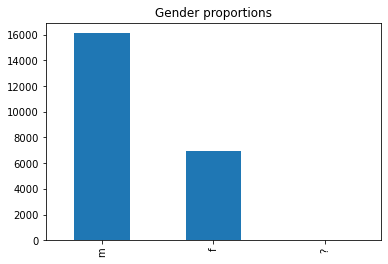

In [11]:
characters['gender'].value_counts().plot(kind='bar', title='Gender proportions')

### Descriptive statistics for age

How are the ages of men and women different in this dataset. To start with we need to be able to select a list of the ages of all men or all women.

In [12]:
characters.loc[(characters['gender'] == 'f'), 'age'].head()

0    35.0
1     NaN
2     NaN
3    46.0
4    46.0
Name: age, dtype: float64

If I introduce you to the function ```hist()```, which produces histograms, we can now compare the age distributions for men and for women.

It may be instructive to play around with some of the code here. For instance, what happens if you take the 'age < 90' condition out? Why? What happens if you change the number of bins?

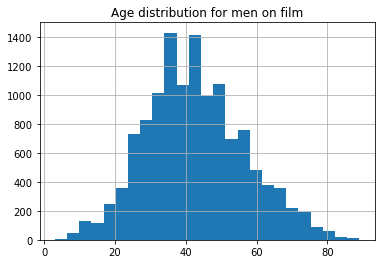

In [13]:
characters.loc[(characters['gender'] == 'm') & (characters['age'] < 90), 'age'].hist(bins = 25)
plt.title('Age distribution for men on film')
plt.show()

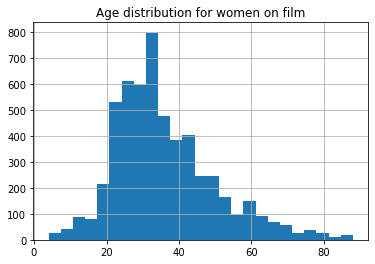

In [14]:
characters.loc[(characters['gender'] == 'f') & (characters['age'] < 90), 'age'].hist(bins = 25)
plt.title('Age distribution for women on film')
plt.show()

### Inferential statistics: how to test a difference of means

Those distributions look a little different visually, but seem to be centered *roughly* in the same place (roughly, our thirties or early forties). Are they significantly different, or could the differences be explained by chance? One simple way to pose this question is to ask how likely it is that these two samples came from populations with the same age distribution. Or to put it a little more narrowly: how likely is it that they came from populations with the same mean age?

The Python for this test is very simple: it's called a "t test," and we could do it in one line of code. But I don't want to just rehearse a formula here; I'd like to review the mental model we're applying when we perform a statistical test of this kind.

H<sub>0</sub> (null hypothesis): the mean age for male characters (in the whole population) is the same as for women.

H<sub>A</sub> (alternative hypothesis): the mean age for women is different than for men.

We can already guess that "different" here is likely to mean "female characters are younger on average," but since I didn't formulate a specific directional hypothesis before inspecting the data I'm going to be conservative and make this a "two-tailed" test, which means that we're going to consider the probability that random sampling variation would produce a difference of means equal to the observed one in *either* direction. We'll be unable to dismiss the null hypothesis if that probability is .05 or higher.

So first of all, what actually is the size of the difference between sample means?

In [15]:
characters.loc[(characters['gender'] == 'm') & (characters['age'] < 90), 'age'].describe()

count    12749.000000
mean        42.661464
std         14.067040
min          3.000000
25%         33.000000
50%         42.000000
75%         52.000000
max         89.000000
Name: age, dtype: float64

In [16]:
characters.loc[(characters['gender'] == 'f') & (characters['age'] < 90), 'age'].describe()

count    5491.000000
mean       35.971044
std        13.825996
min         4.000000
25%        26.000000
50%        33.000000
75%        43.000000
max        88.000000
Name: age, dtype: float64

The difference between 42.66 and 35.97 is approximately 6.7 years.

How often would that difference occur by chance, if both samples were drawn from a population with the same age distribution? We could use statistical formulas here, but to give you an intuitive sense of what's actually happening, let's simulate the *sampling distribution* of the mean ages we would get if gender made no difference in age. In that case our our "ages of men" and "ages of women" would simply be two random samples drawn from the same underlying population, "ages of all characters." There would still be some difference in their means. How often would that difference be equal to or larger than 6.7 years?

Of course, we can't really sample all characters in film. We don't have a list of all characters! But it turns out that you can get a very good simulation of sampling variation in a population by randomly *resampling* an existing sample. 

There are a variety of ways to do the resampling; here we're going to do a "permutation test." We'll combine the ages of all characters into a single pool. 

In [17]:
mensages = characters.loc[(characters['gender'] == 'm') & (characters['age'] < 90), 'age']
womensages = characters.loc[(characters['gender'] == 'f') & (characters['age'] < 90), 'age']
charactersages = mensages.append(womensages)  # Note that we're appending Series rather than lists
                                              # If these were regular lists, you'd need to "extend" instead.

Now we can simulate what would happen if the ages of men and women were drawn from the same distribution. We'll reshuffle the pool ten thousand times. Each time, we'll divide it into two random groups (since in this simulation, gender makes no difference to age distribution). We'll call the first 5491 ages "women" and the next 12,749 "men." Finally, we'll take the difference of means between the two groups, and keep track of all the differences we get. Ten thousand of them! How would they be distributed?

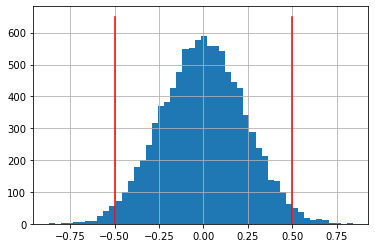

In [18]:
tenthousanddiffs = []

for i in range(10000):
    thissample = charactersages.sample(frac = 1.0, replace = False)  # frac = 1.0 just says "a sample of equal length"
                                                                     # i.e., reshuffle the list
    women = thissample[0: 5491]
    men = thissample[5491: ]
    diff = men.mean() - women.mean()
    tenthousanddiffs.append(diff)
    
tenthousanddiffs = pd.Series(tenthousanddiffs) # To use the .hist() plotting method
                                               # we need to turn this list into a pandas
                                               # object, like a single column of a data frame.
                                               # This is called a Series.
tenthousanddiffs.hist(bins = 50)
plt.plot([-0.5, -0.5], [0, 650], 'red')
plt.plot([0.5, 0.5], [0, 650], 'red')

This is the range of differences we would get through random sampling variation. 

We can ask how often the absolute difference of samples is greater than any value. For instance, how often would we randomly get differences of half a year or more between the mean ages of the two groups? We can find out by looking at the two "tails" of the above distribution, above 0.5  and below -0.5. How many samples are we talking about?

In [19]:
tailcount = sum(abs(tenthousanddiffs) > .5)
print("That happens ", tailcount, "times, for a probability of ", tailcount / 10000)

That happens  306 times, for a probability of  0.0306


What about the actual difference we observed?

In [20]:
observeddiff = mensages.mean() - womensages.mean()
print("The observed difference of means was", observeddiff)

tailcount = sum(abs(tenthousanddiffs) > observeddiff)
print("That happens ", tailcount, "times, for a probability of ", tailcount / 10000)

The observed difference of means was 6.690420118437949
That happens  0 times, for a probability of  0.0


In short, it's *very* unlikely that we could get two samples like this from the same population.

Here's a shortcut way of doing the same calculation. (There are technically some differences here, because the formula used in a t test assumes that the distribution of ages is *roughly* shaped like a bell curve. The permutation test we performed is actually a little more flexible. But it's a small difference in this case, because fictional ages are close enough to a bell curve.)

In [21]:
from scipy.stats import ttest_ind
ttest_ind(mensages, womensages)

Ttest_indResult(statistic=29.616545264882166, pvalue=2.5708626216627163e-188)

The ```pvalue``` there is estimating the probability of getting a difference this extreme if there were in reality no difference between the population means. Again, it's a very low probability. The exponent is -188!

### Grouping and summarizing data

You can see above that men outnumber women on film. The amount of dialogue assigned to the two groups is also unequal. In part that's simply because there are more men.

But it's even more unequal than we would expect from the sheer number of men and women. The *average* amount of dialogue is also unequal.

In [22]:
characters.groupby('gender', as_index = False)['words'].mean()

,gender,words
0,?,281.400000
1,f,850.478513
2,m,932.652988


Women speak on average 850 words per film in this dataset; men 933.

Notice how we used the ```.groupby()``` function to figure this out. It divides a Pandas dataframe into subframes based on the value of the column we pass in as a parameter. Once we've done that we can select a column ```['words']``` in all of those subframes, and calculate the mean value of the column.

By the way, how often would we see a difference as big as 850 and 933 if volubility were in fact equally distributed?

In [23]:
# Try writing a few lines of pandas code here that use a t_test 
# to test the significance of the difference between sample means.
# You'll need to start by constructing an expression that gives you a list
# of the number of words spoken by all women, or all men -- just as we did with age.

# Note: if you're writing more than three lines of code here, you're writing
# more than you need.

### Our mission in class on Monday

In class on Monday, we're going to use the ```.groupby()``` function to divide the ```characters``` data frame by film (```script_id```). Then we'll create a new dataframe where each row is a film, and a new column reports the proportion of feminine dialogue in each film.

Finally we'll pair that dataframe with the ```movies``` dataframe, so we also have the release date for each film. Then we'll ask whether there's been any trend toward gender equality over time. Does the release date of a film correlate positively with the proportion of dialogue spoken by women?

Here's a first step in the process, summing the words spoken by all characters in a film:

In [24]:
groupedbyscriptandgender = characters.groupby(['script_id', 'gender'], as_index = False)['words'].sum()
groupedbyscriptandgender.head()

,script_id,gender,words
0,280,f,3763
1,280,m,2631
2,623,f,1524
3,623,m,7584
4,625,f,155


### Going from a summary by script-and-gender to a percentage of dialogue by women

We used .groupby() to add up all the words spoken by men and by women for each film.

Now we want to turn that into a percentage of words by women, which is a bit more complicated, because it involves a complex operation on two rows at once. We can't easily do that in a single line, and will need to write a loop.

To make sure you can understand how the loop works, let's start by exploring the output of the .groupby() function.

In [25]:
groupedbyscript = groupedbyscriptandgender.groupby('script_id')

In [26]:
ctr = 0
for a, b in groupedbyscript:
    ctr += 1
    print(a)
    print(b)
    if ctr > 3:
        break

280
   script_id gender  words
0        280      f   3763
1        280      m   2631
623
   script_id gender  words
2        623      f   1524
3        623      m   7584
625
   script_id gender  words
4        625      f    155
5        625      m   4246
630
   script_id gender  words
6        630      f   1073
7        630      m   9059


You'll notice that groupby returns an iterator across pairs, where the first element in each pair is the label from the column that did the grouping—e.g. ```script_id``` 280--and the second element is a sub-dataframe representing the grouped rows.

### Now a loop that turns each of these separate dataframes into a line in a new dataframe

Our strategy for creating a new dataframe is to build two lists that will become the columns. Since they're built in parallel, one step at a time, they will align when we're done.

In [27]:
script_ids = []
gender_ratios = []

for script_id, df in groupedbyscriptandgender.groupby('script_id'):
    total_words = df['words'].sum()
    
    if total_words < 1:
        continue     # a pretty weird script with zero total words; we can skip it
    else:
        womens_words = df.loc[df['gender'] == 'f', 'words']
        
        if len(womens_words) < 1:
            womens_words = 0
        else:
            womens_words = int(womens_words)
        
        ratio = womens_words / total_words   # now we have the ratio
        
        script_ids.append(script_id)   # append to the first list
        gender_ratios.append(ratio)   # and the second

ratio_df = pd.DataFrame({'script_id': script_ids, 'spokenbywomen': gender_ratios})
# that line turns our two columns into a data frame

ratio_df.head()

,script_id,spokenbywomen
0,280,0.588520
1,623,0.167325
2,625,0.035219
3,630,0.105902
4,633,0.095913


### To get release year in this data, we need to join it with the movies dataframe

We can't analyze historical trends in the percentage of dialogue spoken by women unless we can pair each movie's percentage with its release year. This requires adding data contained in the movies dataframe.

The next cell just refreshes that dataframe, by reading it from file again, in case we've changed it in some way above.

In [28]:
movies = pd.read_csv('meta_data7.csv', encoding = 'latin1')
movies.head()

,script_id,imdb_id,title,year,gross,lines_data
0,1534,tt1022603,(500) Days of Summer,2009,37.0,7435445256774774443342577775657744434444564456...
1,1512,tt0147800,10 Things I Hate About You,1999,65.0,1777752320274533344457777722433777334443764677...
2,1514,tt0417385,12 and Holding,2005,NaN,5461357777754212454544441367774433446547647753...
3,1517,tt2024544,12 Years a Slave,2013,60.0,4567334777777777777777447777756477777444777777...
4,1520,tt1542344,127 Hours,2010,20.0,453513352345765766777777773340


In order to do a "join" on two dataframes, the one on the "right" has to have an *index* that aligns with a *column* in the one on the left. For a fuller understanding of the logic of joins, check out [the syntax of the .join() method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) or [this blog post](https://towardsdatascience.com/pandas-join-vs-merge-c365fd4fbf49) if you need a fuller account.

In any case, we're going to make ```script_id``` the index of ```movies.```

In [29]:
movies = movies.set_index('script_id')

In [30]:
movies.head()

,imdb_id,title,year,gross,lines_data
script_id,,,,,
1534,tt1022603,(500) Days of Summer,2009,37.0,7435445256774774443342577775657744434444564456...
1512,tt0147800,10 Things I Hate About You,1999,65.0,1777752320274533344457777722433777334443764677...
1514,tt0417385,12 and Holding,2005,NaN,5461357777754212454544441367774433446547647753...
1517,tt2024544,12 Years a Slave,2013,60.0,4567334777777777777777447777756477777444777777...
1520,tt1542344,127 Hours,2010,20.0,453513352345765766777777773340


In [36]:
movies.drop('lines_data', axis = 1, inplace = True)
movie_ratios = ratio_df.join(movies, on = 'script_id', how = 'left')
movie_ratios.head()

,script_id,spokenbywomen,imdb_id,title,year,gross
0,280,0.588520,tt0112579,The Bridges of Madison County,1995,142.0
1,623,0.167325,tt0179626,15 Minutes,2001,37.0
2,625,0.035219,tt0062622,2001: A Space Odyssey,1968,376.0
3,630,0.105902,tt0307901,25th Hour,2002,19.0
4,633,0.095913,tt1019452,A Serious Man,2009,10.0


In [37]:
movie_ratios.sort_values(by = 'spokenbywomen', ascending = False)

,script_id,spokenbywomen,imdb_id,title,year,gross
1161,4723,1.000000,tt0114011,Now and Then,1995,54.0
1699,7695,1.000000,tt0435625,The Descent,2005,35.0
765,3124,0.993541,tt0929632,Precious,2009,55.0
1912,8614,0.965550,tt1663655,Martyrs,2015,NaN
1877,8480,0.933750,tt0104389,The Hand That Rocks the Cradle,1992,184.0
...,...,...,...,...,...,...
1868,8423,0.000000,tt0089537,Mala Noche,1986,NaN
1649,7440,0.000000,tt0112740,Crimson Tide,1995,182.0
984,4038,0.000000,tt0068408,Conquest of the Planet of the Apes,1972,NaN
1839,8257,0.000000,tt1663202,The Revenant,2015,147.0


### Visualization

I'll explain this more next week.

<AxesSubplot:xlabel='year', ylabel='spokenbywomen'>

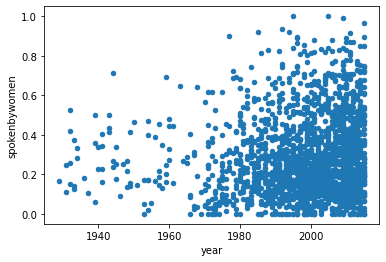

In [33]:
movie_ratios.plot('year', 'spokenbywomen', kind = 'scatter')

In [38]:
from scipy.stats import pearsonr
import numpy as np

pearsonr(movie_ratios['year'], movie_ratios['spokenbywomen'])

(0.09170051837762483, 4.007207430817736e-05)

In [39]:
pearsonr(movie_ratios['gross'][~np.isnan(movie_ratios['gross'])], 
                               movie_ratios['spokenbywomen'][~np.isnan(movie_ratios['gross'])])

(-0.10251800480225916, 2.8228185448613996e-05)

In [41]:
pearsonr(movie_ratios['gross'][~np.isnan(movie_ratios['gross'])], 
                               movie_ratios['year'][~np.isnan(movie_ratios['gross'])])

(-0.2683465910462182, 8.332923515748268e-29)

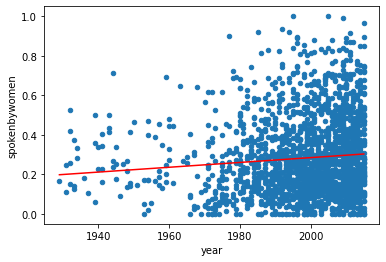

In [40]:
movie_ratios.plot('year', 'spokenbywomen', kind = 'scatter')
x = movie_ratios['year']
y = movie_ratios['spokenbywomen']
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'r')

<AxesSubplot:xlabel='year', ylabel='spokenbywomen'>

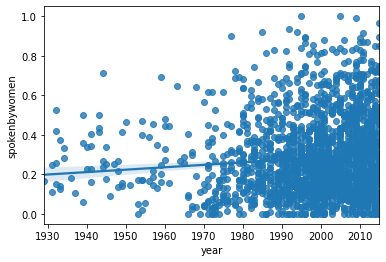

In [42]:
import seaborn as sns
sns.regplot(x = movie_ratios['year'], y = movie_ratios['spokenbywomen'])

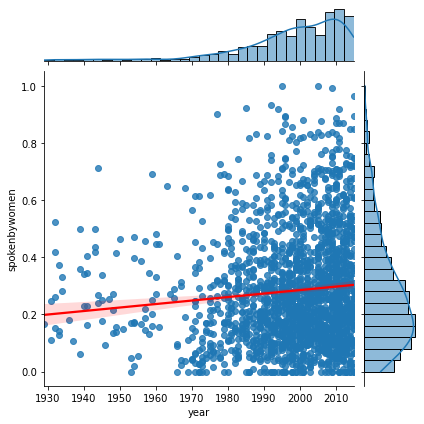

In [43]:
sns.jointplot(x = movie_ratios['year'], y = movie_ratios['spokenbywomen'],
              kind = 'reg', joint_kws={'line_kws':{'color':'red'}})

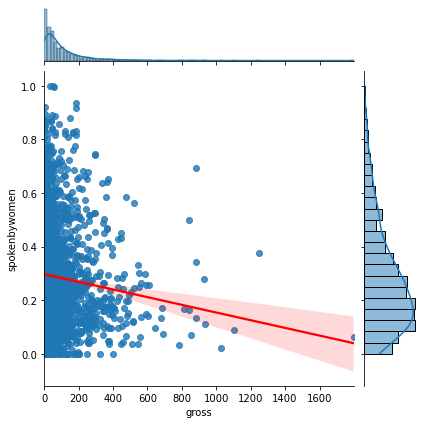

In [44]:
filtered_ratios = movie_ratios.loc[~np.isnan(movie_ratios['gross']), : ]
sns.jointplot(x = filtered_ratios['gross'], y = filtered_ratios['spokenbywomen'],
              kind = 'reg', joint_kws={'line_kws':{'color':'red'}})

In [45]:
import statsmodels.api as sm # import statsmodels 
X = filtered_ratios[["gross", "year"]] ## X usually means our input variables (or independent variables)
y = filtered_ratios["spokenbywomen"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          spokenbywomen   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     11.03
Date:                Sun, 07 Feb 2021   Prob (F-statistic):           1.75e-05
Time:                        21:35:57   Log-Likelihood:                 357.23
No. Observations:                1662   AIC:                            -708.5
Df Residuals:                    1659   BIC:                            -692.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6909      0.949     -1.782      0.075      -3.552       0.170
gross         -0.0001   3.54e-05     -3.487      0.001      -0.000    -5.4e-05
year           0.0010      0.000      2.095      0.036    6.34e-05       0.002
==============================================================================
Omnibus:                      194.602   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.616
Skew:                           0.944   Prob(JB):                     3.46e-58
Kurtosis:                       3.508   Cond. No.                     3.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""